In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame
from tabulate import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import t, f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [3]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.unicode_minus"] = False

In [4]:
origin = read_excel("https://data.hossam.kr/mldata/fish.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


(39,) [ 155.58850866  167.46804439  773.47205185  252.88717535  726.13072227
  204.31826385  925.97854707  360.50382493  844.83106848  158.53122981
  753.11413377  123.81449531 -305.75100193   65.89358214  128.21623375
  188.6960309    51.52539231]
[훈련결과 시각화]


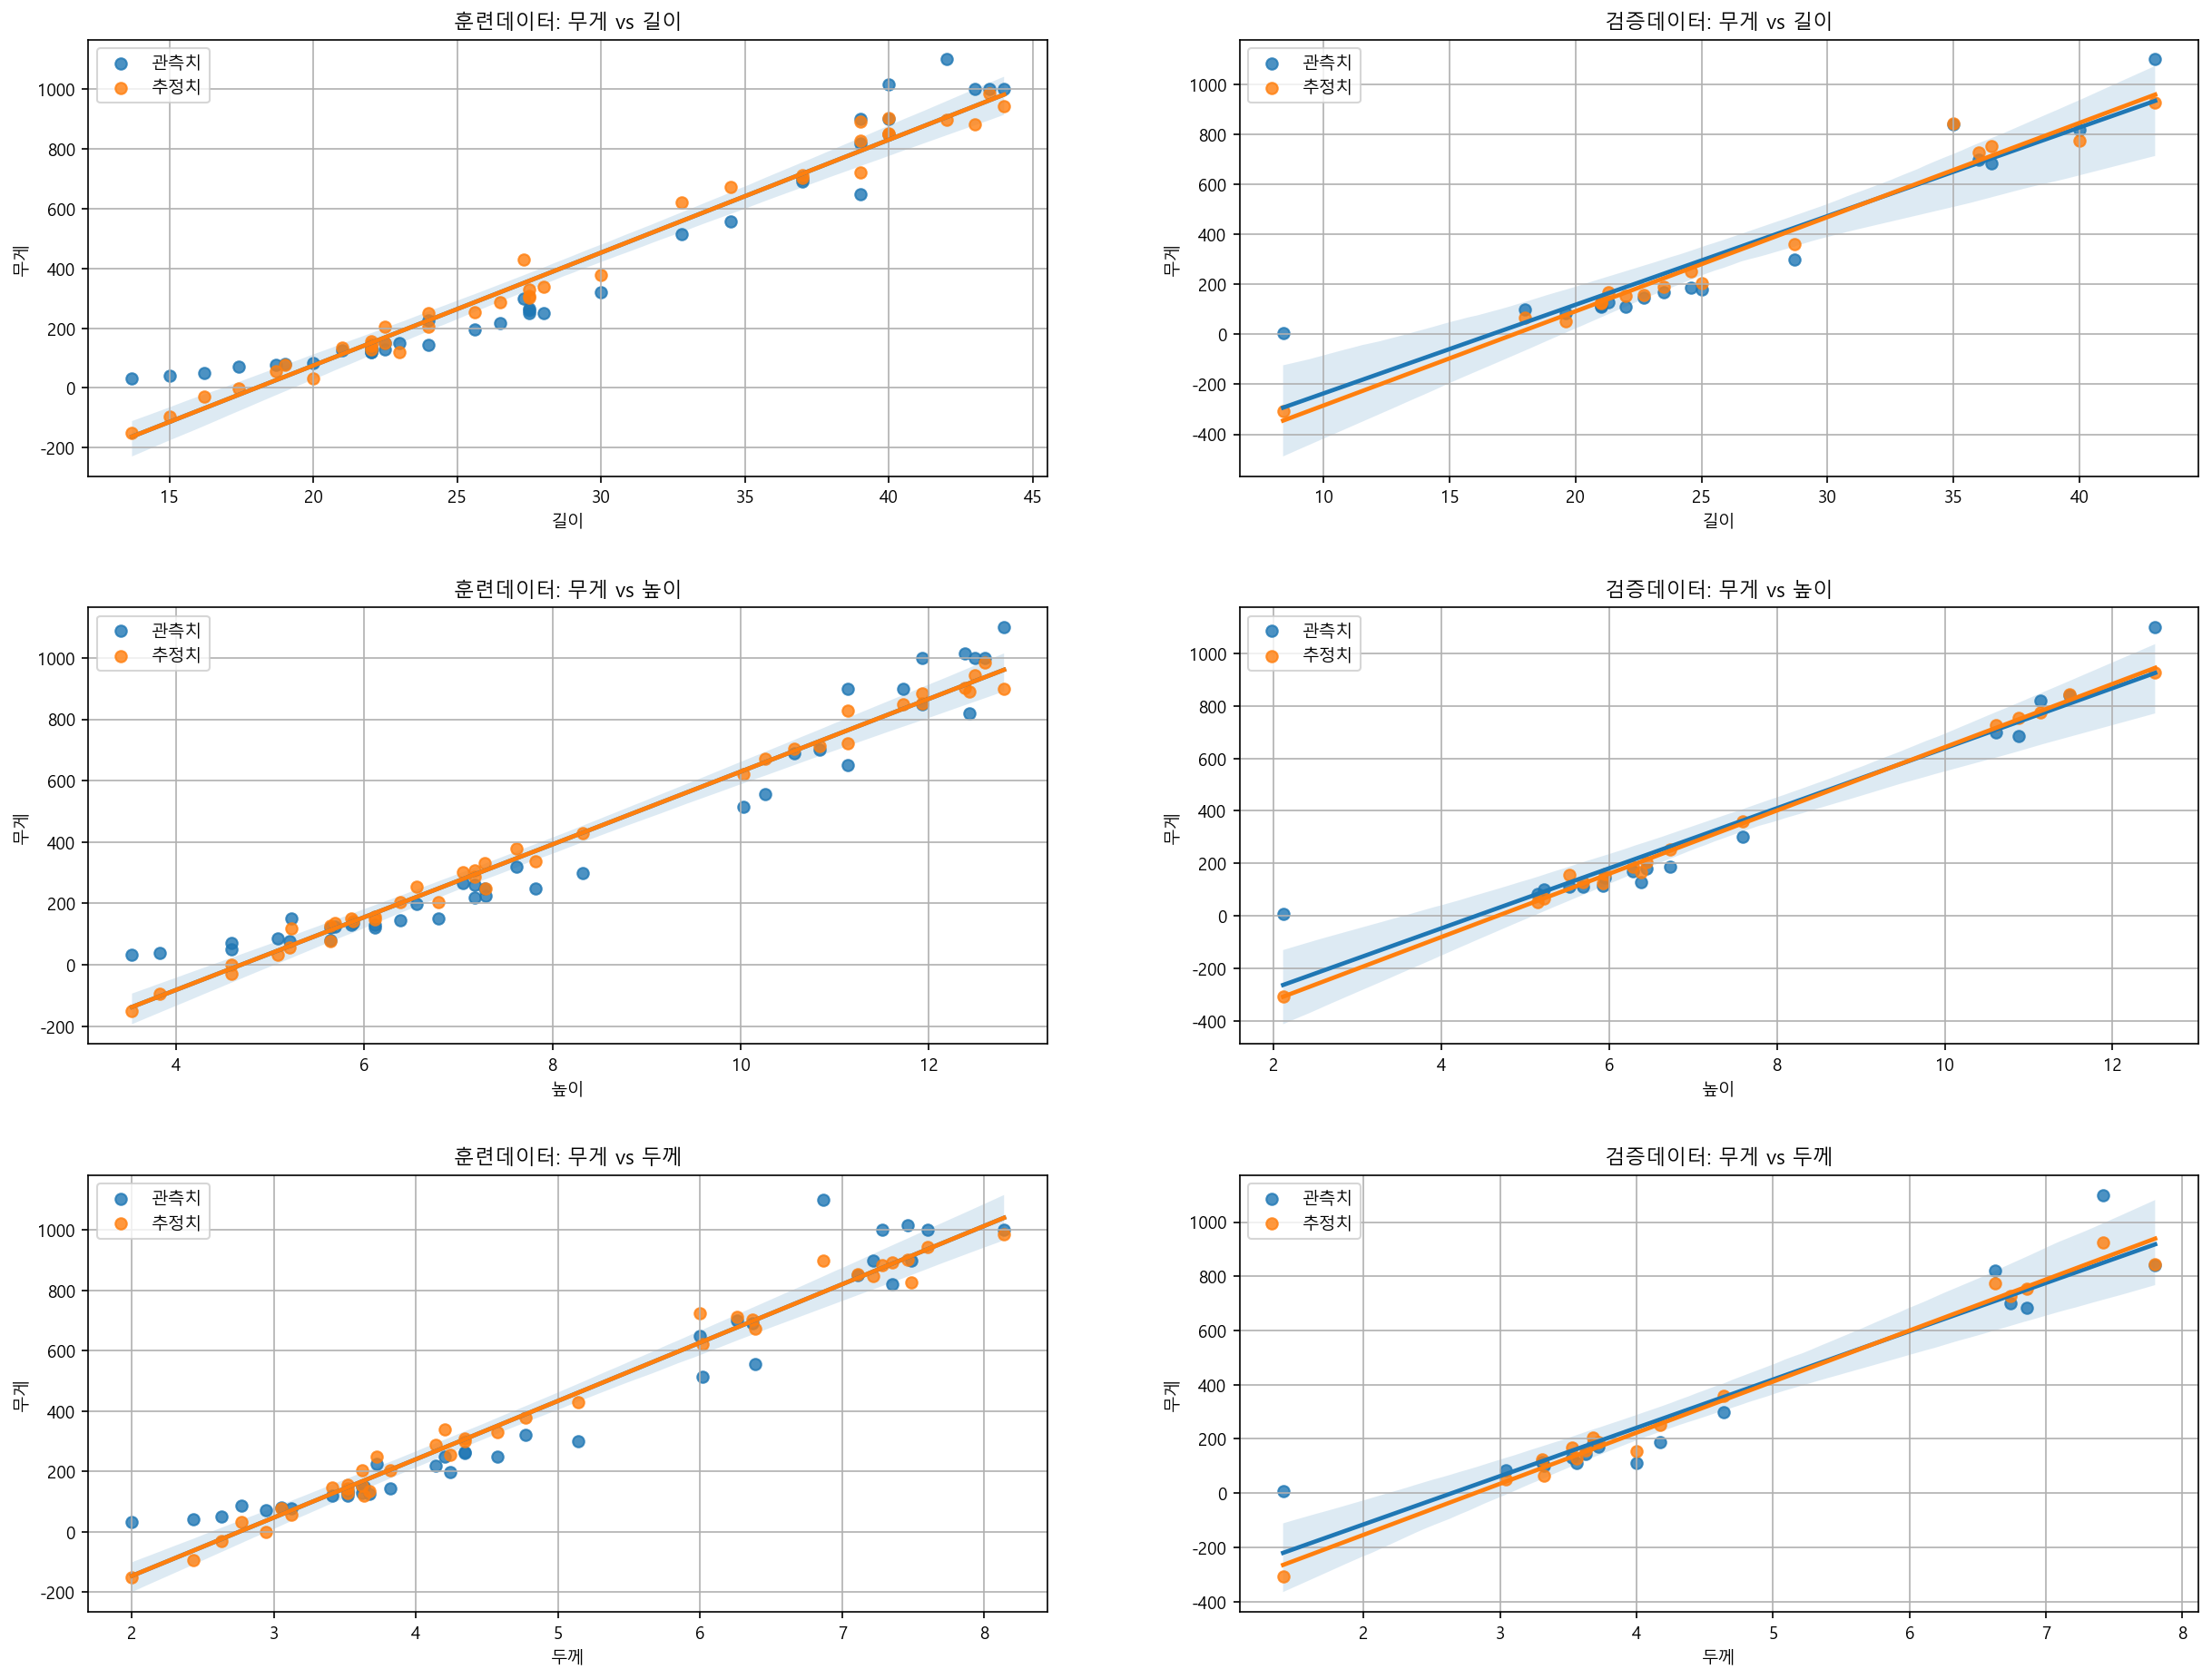

[성능지표]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.949944 |     0.919246 |
| 평균절대오차(MAE)             |      61.8824 |      58.2871 |
| 평균제곱오차(MSE)             |      6089.38 |      8828.88 |
| 평균오차(RMSE)                |      78.0345 |      93.9621 |
| 평균 절대 백분오차 비율(MAPE) |      46.2303 |       327.91 |
| 평균 비율 오차(MPE)           |      22.7633 |      304.702 |
+-------------------------------+--------------+--------------+

[회귀식]
무게 = 6.182 * 길이 + 57.255 * 높이 + 70.281 * 두께 + -577.582

[훈련데이터에 대한 결과보고]
+----+------------+------------+--------------------+------------+------------------+-------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |   β(표준화 계수) |     t |   유의확률 |     VIF |
|----+------------+------------+--------------------+------------+------------------+-------+------------+------

In [6]:
# --------------------------------
# 데이터 분할
# --------------------------------
yname = '무게'
x = origin.drop('무게', axis=1)
y = origin[yname]
xnames = list(x.columns)
#print(xnames)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
#print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# --------------------------------
# 회귀분석
# --------------------------------
# 분석모델 생성
model = LinearRegression(n_jobs=-1)
fit = model.fit(x_train, y_train)



# --------------------------------
# 훈련, 검증 데이터에 대한 예측치
# --------------------------------
y_train_pred = fit.predict(x_train)
y_test_pred = fit.predict(x_test)
print(y_train_pred.shape, y_test_pred)

# 반복 수행을 위해 훈련/검증 데이터를 하나로 묶음
target = [[x_train, y_train, y_train_pred], [x_test, y_test, y_test_pred]]

# 성능지표 저장용 리스트
result_data = []

# --------------------------------
# 시각화 및 성능지표 계산
# --------------------------------
# 시각화 시작
print("[훈련결과 시각화]")
size = len(xnames)

# 서브플롯에서 바깥의 반복문이 열(i)을 담당하도록 구성 (반복문 하나 그냥 낭비하기 싫어서 그래프 그릴때 씀)
fig, ax = plt.subplots(len(xnames), 2, figsize=(20, 5*size), dpi=150)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(target):
    result = {
        "결정계수(R2)": r2_score(v[1], v[2]),
        "평균절대오차(MAE)": mean_absolute_error(v[1], v[2]),
        "평균제곱오차(MSE)": mean_squared_error(v[1], v[2]),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(v[1], v[2])),
        "평균 절대 백분오차 비율(MAPE)": np.mean(np.abs((v[1] - v[2]) / v[1]) * 100),
        "평균 비율 오차(MPE)": np.mean((v[1] - v[2]) / v[1] * 100)
    }
    
    result_data.append(result)
    
    # 서브플롯에서 바깥의 반복문이 열(i)을 담당하도록 구성하였으므로, 내부 반복문은 행(변수 종류별,j)을 담당
    for j, w in enumerate(xnames):
        sb.regplot(x=v[0][w], y=v[1], ci=95, ax=ax[j][i], label='관측치')
        sb.regplot(x=v[0][w], y=v[2], ci=0, ax=ax[j][i], label='추정치')
        ax[j][i].set_title(f"훈련데이터: {yname} vs {w}" if i == 0 else f"검증데이터: {yname} vs {w}")
        ax[j][i].legend()
        ax[j][i].grid(True)

plt.show()
plt.close()

result_df = DataFrame(result_data, index=["훈련데이터", "검증데이터"])
print("[성능지표]")
print(tabulate(result_df.T, headers='keys', tablefmt='psql', showindex=True, numalign="right"), end="\n\n")

# --------------------------------
# 회귀식
# --------------------------------
expr = "{yname} = ".format(yname=yname)

for i, v in enumerate(xnames):
    expr += "%0.3f * %s + " % (fit.coef_[i], v)

expr += "%0.3f" % fit.intercept_
print("[회귀식]")
print(expr, end="\n\n")

# --------------------------------
# 결과보고
# --------------------------------
for i, v in enumerate(target):
    print("[훈련데이터에" if i == 0 else "[검증데이터에", "대한 결과보고]")
    
    target_x = v[0]
    target_y = v[1]
    target_y_pred = v[2]
    
    # 잔차
    resid = target_y - target_y_pred

    # 절편과 계수를 하나의 배열로 결합
    params = np.append(fit.intercept_, fit.coef_)

    # 검증용 독립변수에 상수항 추가
    design_x = target_x.copy()
    design_x.insert(0, '상수', 1)

    dot = np.dot(design_x.T,design_x)   # 행렬곱
    inv = np.linalg.inv(dot)            # 역행렬
    dia = inv.diagonal()                # 대각원소

    # 제곱오차
    MSE = (sum((target_y-target_y_pred)**2)) / (len(design_x)-len(design_x.iloc[0]))

    se_b = np.sqrt(MSE * dia)           # 표준오차
    ts_b = params / se_b                # t값

    # 각 독립수에 대한 pvalue
    p_values = [2*(1-t.cdf(np.abs(i),(len(design_x)-len(design_x.iloc[0])))) for i in ts_b]

    # VIF
    vif = [variance_inflation_factor(target_x, list(target_x.columns).index(v)) for i, v in enumerate(target_x.columns)]

    # 표준화 계수
    train_df = target_x.copy()
    train_df[target_y.name] = target_y
    scaler = StandardScaler()
    std = scaler.fit_transform(train_df)
    std_df = DataFrame(std, columns=train_df.columns)
    std_x = std_df[xnames]
    std_y = std_df[yname]
    std_model = LinearRegression()
    std_fit = std_model.fit(std_x, std_y)
    beta = std_fit.coef_

    # 결과표 구성하기
    result_df = DataFrame({
        "종속변수": [yname] * len(xnames),
        "독립변수": xnames,
        "B(비표준화 계수)": np.round(params[1:], 4),
        "표준오차": np.round(se_b[1:], 3),
        "β(표준화 계수)": np.round(beta, 3),
        "t": np.round(ts_b[1:], 3),
        "유의확률": np.round(p_values[1:], 3),
        "VIF": vif,
    })

    #result_df
    print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True), end="\n\n")

    resid = target_y - target_y_pred        # 잔차
    dw = durbin_watson(resid)               # 더빈 왓슨 통계량
    r2 = r2_score(target_y, target_y_pred)  # 결정계수(설명력)
    rowcount = len(target_x)                # 표본수
    featurecount = len(target_x.columns)    # 독립변수의 수

    # 보정된 결정계수
    adj_r2 = 1 - (1 - r2) * (rowcount-1) / (rowcount-featurecount-1)

    # f값
    f_statistic = (r2 / featurecount) / ((1 - r2) / (rowcount - featurecount - 1))

    # Prob (F-statistic)
    p = 1 - f.cdf(f_statistic, featurecount, rowcount - featurecount - 1)

    tpl = "𝑅^2(%.3f), Adj.𝑅^2(%.3f), F(%.3f), P-value(%.4g), Durbin-Watson(%.3f)"
    print(tpl % (r2, adj_r2, f_statistic, p, dw), end="\n\n")

    # 결과보고
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %0.3f, p %s 0.05)."

    print(tpl % (
        yname,
        ",".join(xnames),
        "유의하다" if p <= 0.05 else "유의하지 않다",
        len(target_x.columns),
        len(target_x.index)-len(target_x.columns)-1,
        f_statistic,
        "<=" if p <= 0.05 else ">"), end="\n\n")

    # 독립변수 보고
    for n in xnames:
        item = result_df[result_df['독립변수'] == n]
        coef = item['B(비표준화 계수)'].values[0]
        pvalue = item['유의확률'].values[0]

        s = "%s의 회귀계수는 %0.3f(p %s 0.05)로, %s에 대하여 %s."
        k = s % (n,
                coef,
                "<=" if pvalue <= 0.05 else '>',
                yname,
                '유의미한 예측변인인 것으로 나타났다' if pvalue <= 0.05 else '유의하지 않은 예측변인인 것으로 나타났다'
        )

        print(k)
        
    print("")
    


>잘린 부분은 text editor를 누르면 다 보인다.